# Effect size extrapolation

In the [last notebook], we calculated emperical and distribution-based power for five types of statistical tests:
* One Sample T test
* Independent Sample t test 
* One way ANOVA, 3 groups
* One way ANOVA, 8 groups
* Linear correlation

We will now evaluate 

In [1]:
import copy
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
# import statsmodels.api as sms
import statsmodels.formula.api as smf

import emp_power.traditional as trad
import emp_power.effects as eff
import emp_power.plot as plot

% matplotlib inline
sn.set_style('ticks')

In [2]:
warnings.filterwarnings('ignore')

In [3]:
num_rounds = 100
alpha = 0.05
counts = np.arange(5, 100, 10)
colormap = 'Spectral'
overwrite = True

In [4]:
sim_location = './simulations'
if not os.path.exists(sim_location):
    raise ValueError('The power simulations do not exist.'
                     'Please go back to notebooks 2 and 3 and'
                     'calculate power.'
                     )

In [5]:
colors = sn.color_palette(colormap, n_colors=len(counts))
check_color = {count: colors[i] for i, count in enumerate(counts)}

In [6]:
# tests = ['ttest_1', 'ttest_ind', 'anova_3', 'anova_8', 'correlation']
tests = ['ttest_1']

In [7]:
extrapolated = ['f_power', 't_power', 'z_power']

In [8]:
distributions = {'ttest_1': {'clean_name': 'One Sample\nT Test',
                               'num_groups': 2,
                               'input_dir': './simulations/emperical_power/ttest_1',
                               'return_fp': './simulations/extrapolation/ttest_1.txt'
                               },
                 'ttest_ind': {'clean_name': 'Independent Sample\n T Test',
                               'num_groups': 2,
                               'input_dir': './simulations/emperical_power/ttest_ind',
                               'return_fp': './simulations/extrapolation/ttest_ind.txt'
                               },
                 'anova_3': {'clean_name': 'One way ANOVA\n(3 groups)',
                             'num_groups': 3,
                             'input_dir': './simulations/emperical_power/anova_3',
                             'return_fp': './simulations/extrapolation/anova_3.txt'
                             },
                 'anova_8': {'clean_name': 'One way ANOVA\n(8 groups)',
                             'num_groups': 8,
                             'input_dir': './simulations/emperical_power/anova_8',
                             'return_fp': './simulations/extrapolation/anova_8.txt'
                             },
                 'correlation': {'clean_name': 'Correlation',
                                 'num_groups': 2,
                                 'input_dir': './simulations/emperical_power/correlation',
                                 'return_fp': './simulations/extrapolation/correlation.txt'
                                 }
                 }

We'll start by calculating the emperical and extrapolated effect sizes for the parametric tests.

In [9]:
for test_name in tests:
    power_dir = distributions[test_name]['input_dir']
    num_groups = distributions[test_name]['num_groups']
    return_fp = distributions[test_name]['return_fp']
    
    if not os.path.exists(power_dir):
        raise ValueError('%s does not exist' % power_dir)
        
    summaries = []
    
    # Loops through the rounds
    for i in range(num_rounds):
        # Loads through the power simulation for the round
        power_fp = os.path.join(power_dir, 'simulation_%i.p' % i)
        
        with open(power_fp, 'rb') as f_:
            sim = pickle.load(f_)
        
        # Pulls the previously calculated power values
        counts = sim['counts']
        emperical = sim['emperical_power']
        empr_shape = emperical.shape
        z_effect = eff.z_effect(counts, emperical)
        t_effect = eff.t_effect(counts, emperical)
        f_effect = eff.f_effect(counts, emperical, groups=num_groups)
        
        num_obs = (empr_shape[0] * empr_shape[1])
        run_summary = pd.DataFrame({
                    'counts': np.hstack([counts] * empr_shape[0]),
                    'emperical_power': np.hstack(emperical),
                    'traditional_power': np.hstack([sim['traditional_power']] * empr_shape[0]),
                    'sim_pos': np.hstack([np.arange(empr_shape[1]) + (i + 1) * 10 
                                          for i in range(empr_shape[0])]),
                    'z_effect': np.hstack(z_effect),
                    't_effect': np.hstack(t_effect),
                    'f_effect': np.hstack(f_effect),
                    'z_power': np.hstack([eff.z_power(counts, np.nanmean(z_effect))]
                                         * empr_shape[0]),
                    't_power': np.hstack([eff.t_power(counts, np.nanmean(t_effect))]
                                         * empr_shape[0]),
                    'f_power': np.hstack([eff.f_power(counts, np.nanmean(f_effect), groups=num_groups)]
                                         * empr_shape[0]),
                    })
        run_summary['color'] = run_summary['counts'].apply(lambda x: check_color[x])
        run_summary['test'] = test_name
        run_summary['clean_name'] = distributions[test_name]['clean_name']
        run_summary['round'] = i
        run_summary['fit_f-mean'] = np.nanmean(f_effect)
        run_summary['fit_f-std'] = np.nanstd(f_effect)
        run_summary['fit_f-count'] = np.sum(np.isnan(f_effect) == False) / num_obs
        run_summary['fit_t-mean'] = np.nanmean(t_effect)
        run_summary['fit_t-std'] = np.nanstd(t_effect)
        run_summary['fit_t-count'] = np.sum(np.isnan(t_effect) == False) / num_obs
        run_summary['fit_z-mean'] = np.nanmean(z_effect)
        run_summary['fit_z-std'] = np.nanstd(z_effect)
        run_summary['fit_z-count'] = np.sum(np.isnan(z_effect) == False) / num_obs
        run_summary['index'] = (run_summary['test'] + '.' +  
                                run_summary['round'].apply(lambda x: '%i' % x) + '.' +
                                run_summary['sim_pos'].apply(lambda x: '%i' % x))
        run_summary.set_index('index', inplace=True)
        
        summaries.append(pd.DataFrame(run_summary))
    summaries = pd.concat(summaries)
    summaries.to_csv(return_fp, sep='\t')
    distributions[test_name]['summary'] = summaries


We're going to plot a comparison between the emperical and traditional power calculations, to see if there's a strong relationship. We'll plot the distribution-based power on the x axis and the emperical power on the y axis.

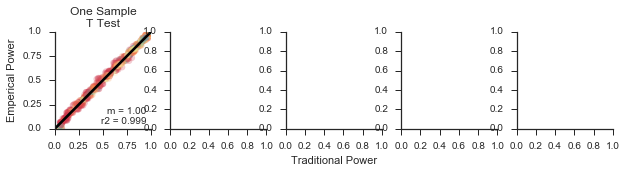

In [10]:
# Sets up the figure and axes
tr_fig, tr_axes = plt.subplots(4, 5)
tr_fig.set_size_inches(10, 8)

# Hides the axes until they're needed
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(False)

sn.despine()

for idx, (test_name, ax) in enumerate(zip(*(tests, tr_axes[0]))):
    summary = distributions[test_name]['summary']
    plot.gradient_regression(ax, y='emperical_power', 
                             x='traditional_power', 
                             gradient='color', 
                             data=summary, 
                             alpha=0.25)
    plot.format_regression_axis(ax)
    ax.set_title(summary['clean_name'].values[0])
    ax.set_xticklabels(ax.get_xticks())
tr_axes[0][0].set_yticklabels(ax.get_yticks())
tr_axes[0][0].set_ylabel('Emperical Power')
tr_axes[0][2].set_xlabel('Traditional Power')

We can also look at the fit data behaves. So, we'll add an additional three rows to the plot, which show the 

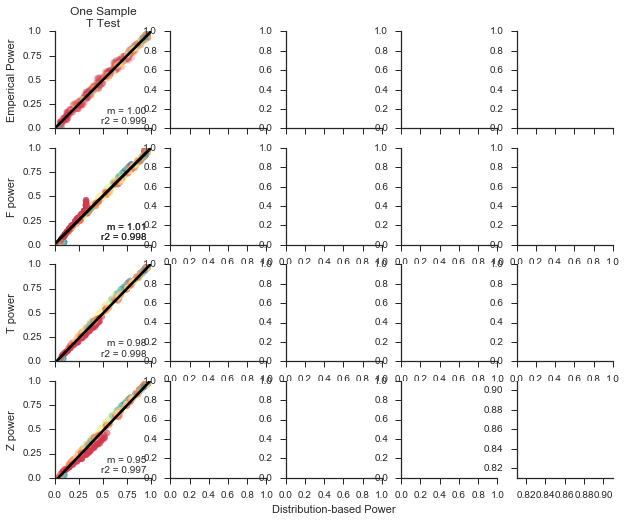

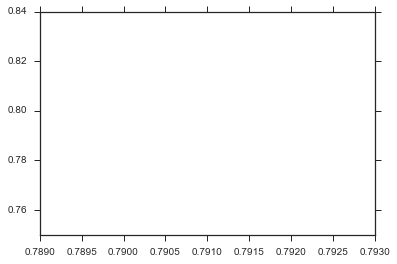

In [13]:
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(True)
for ax in tr_axes[0]:
    ax.set_xticklabels('')
    ax.set_xlabel('')
    
for idc, test_name in enumerate(tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg in zip(*[extrapolated, tr_axes.T[idc][1:]]):
        plot.gradient_regression(ax=ax_reg, 
                            x='traditional_power', 
                            y=metric, 
                            gradient='color', 
                            alpha=0.25,
                            data=summary
                            )
        plot.format_regression_axis(ax_reg)
        if metric == 'z_power':
            ax_reg.set_xticklabels(ax_reg.get_xticks())
        if test_name == tests[0]:
            ax_reg.set_yticklabels(ax_reg.get_yticks())
            ax_reg.set_ylabel(metric.replace('_', ' ').capitalize())
        
tr_axes[-1][2].set_xlabel('Distribution-based Power')
tr_fig

In [ ]:
ax = plt.axes()

gradient_regression(ax=ax_reg, 
                    x='traditional_power', 
                    y='f_power', 
                    gradient='color', 
#                     alpha=0.25,
                    data=summary
                    )
# format_regression_axis(ax)

Let's also look at the residuals of the plot, to make sure that what we're seeing is sane.

In [ ]:
# Sets up the figure and axes
ts_fig, ts_axes = plt.subplots(4, 5)
ts_fig.set_size_inches(10, 8)

# Hides the axes until they're needed
for ax_r in ts_axes[1:]:
    for ax in ax_r:
        ax.set_visible(False)

sn.despine()

for idx, (test_name, ax) in enumerate(zip(*(tests, ts_axes[0]))):
    summary = distributions[test_name]['summary']
    plot.gradient_residuals(ax, 
                            'emperical_power', 
                            'traditional_power', 
                            gradient='counts', 
                            x_resid='traditional_power', 
                            data=summary,
                            alpha=0.25,
                           )
    plot.format_resid_ax(ax, xlim=[-0.1, 1.1], ylim=[-0.3, 0.3])
    ax.set_xticklabels(ax.get_xticks())
    ax.set_title(summary['clean_name'].values[0])
ts_axes[0][0].set_yticklabels(ts_axes[0][0].get_yticks())
ts_axes[0][0].set_ylabel('Residuals')
ts_axes[0][2].set_xlabel('Traditional Power')


Now, we're going to compare the behavior of the extraploated power to the performance of the test based power for the three fitting metrics.

In [ ]:
# Hides the axes until they're needed
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(True)
for ax_r in ts_axes[1:]:
    for ax in ax_r:
        ax.set_visible(True)

for ax in tr_axes[0]:
    ax.set_xticklabels('')
    ax.set_xlabel('')
for ax in ts_axes[0]:
    ax.set_xticklabels('')
    ax.set_xlabel('')

In [ ]:
cmap = sn.color_palette('Spectral', n_colors=len(counts))

In [ ]:
for idc, test_name in enumerate(tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg, ax_resid in zip(*[extrapolated, tr_axes.T[idc][1:], ts_axes.T[idc][1:]]):
        plot.gradient_regression(ax_reg, 
                                 x='traditional_power', 
                                 y=metric, 
                                 gradient='counts', 
                                 cmap='Spectral',
                                 alpha=0.25,
                                 data=summary
                                 )
        
        plot.format_regression_axis(ax_reg)
        plot.gradient_residuals(ax_resid, 
                                x='traditional_power', 
                                y=metric, 
                                gradient='counts', 
                                x_resid='traditional_power', 
                                data=summary,
                                alpha=0.25,
                                )
        plot.format_resid_ax(ax_resid, xlim=[-0.1, 1.1], ylim=[-0.3, 0.3])
        ax_resid.set_yticklabels(ax_resid.get_yticks())

#         if idc == 0:
#             ax_reg.set_yticklabels(ax_reg.get_yticks())
#             ax_reg.set_ylabel(metric.replace('_', ' ').capitalize())
#             ax_resid.set_yticklabels(ax_resid.get_yticks())
#             ax_resid.set_ylabel('residuals \n(%s)' % metric.replace('_', ' ').capitalize())
        if metric == 'z_power':
            ax_reg.set_xticklabels(ax.get_xticks())
            ax_resid.set_xticklabels(ax.get_xticks())

In [ ]:
tr_fig

In [ ]:
ts_fig

Let's next look at the relationship between the extrapolated power the emperical power. We may expect differences in behavior based on the metric used. It's expected that the F metric may behave better than the T or Z metric for a larger number of groups.

In [ ]:
# Sets up the figure and axes
er_fig, er_axes = plt.subplots(3, 5)
er_fig.set_size_inches(10, 6)

es_fig, es_axes = plt.subplots(3, 5)
es_fig.set_size_inches(10, 6)

for idc, test_name in enumerate(tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg, ax_resid in zip(*[extrapolated, er_axes.T[idc], es_axes.T[idc]]):
        plot.gradient_regression(ax_reg, 
                                 x='emperical_power', 
                                 y=metric, 
                                 gradient='counts', 
                                 cmap='Spectral',
                                 alpha=0.25,
                                 data=summary
                                 )
        
        plot.format_regression_axis(ax_reg)
        plot.gradient_residuals(ax_resid, 
                                x='emperical_power', 
                                y=metric, 
                                gradient='counts', 
                                data=summary,
                                alpha=0.25,
                                )
        plot.format_resid_ax(ax_resid, xlim=[-0.1, 1.1], ylim=[-0.3, 0.3])
        ax_resid.set_yticklabels(ax_resid.get_yticks())

It looks like the performance 